In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
# from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import seaborn as sns

In [17]:
wcs = pd.read_csv('./WHCR_Aerial_Observations_1950_2011.txt', sep = '\t')

In [18]:
wcs.columns

Index([u'Year', u'Month', u'Day', u'Survey_year', u'Coordinates', u'X', u'Y',
       u'WHITE', u'JUVE', u'UNK', u'Band', u'Band_condition', u'Observer',
       u'Pilot', u'Aircraft', u'Area', u'Land_Cover', u'Time', u'Weather',
       u'Temperature', u'Comments'],
      dtype='object')

In [19]:
wc_gp = wcs[['Year','Month','Day','Coordinates','X','Y','WHITE','JUVE','UNK','Band','Time']]

In [37]:
wc_gp['date'] = pd.to_datetime(wc_gp.Year*10000+wc_gp.Month*100+wc_gp.Day,format='%Y%m%d')
# pd.to_datetime(wc_gp.Year, wc_gp.Month, wc_gp.Day)

/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [38]:
wc_gp.head()

,Year,Month,Day,Coordinates,X,Y,WHITE,JUVE,UNK,Band,Time,date
0,1950,10,28,Yes,704249.7827,3.114474e+06,2.0,0.0,0.0,NaN,NaN,1950-10-28
1,1950,11,4,Yes,716924.2997,3.126885e+06,2.0,1.0,0.0,NaN,NaN,1950-11-04
2,1950,11,4,Yes,713611.7098,3.125319e+06,3.0,0.0,0.0,NaN,NaN,1950-11-04
3,1950,11,4,Yes,711590.2891,3.120514e+06,2.0,2.0,0.0,NaN,NaN,1950-11-04
4,1950,11,4,Yes,710267.3697,3.120620e+06,2.0,1.0,0.0,NaN,NaN,1950-11-04


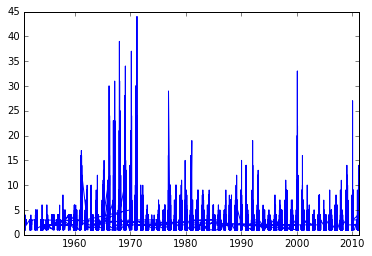

In [39]:
plt.plot(wc_gp['date'], wc_gp['WHITE']+wc_gp['JUVE']+wc_gp['UNK'])

In [32]:
wc_gp.groupby(['Year','Month']).agg('count')

Day  Coordinates    X    Y  WHITE  JUVE  UNK  Band  Time
Year Month                                                          
1950 10       1            1    1    1      1     1    1     0     0
     11      53           53   53   53     53    53   53     0     0
     12      40           40   40   40     40    40   40     0     0
1951 1       34           34   30   30     34    34   34     0     0
     3        9            9    8    8      9     9    9     0     0
     4        2            2    2    2      2     2    2     0     0
     11      22           22   22   22     22    22   22     0     0
     12      19           19   18   18     19    19   19     0     0
1952 1       29           29   29   29     29    29   29     0     0
     2        4            4    4    4      4     4    4     0     0
     3       18           18   18   18     18    18   18     0     0
     10      19           19   19   19     19    19   19     0     0
     11      23           23   23   23     23    23   23     0     0
     12      27           27   27   27     27    27   27     0     3
1953 1       12           12   11   11     12    12   12     0     0
     2        5            5    5    5      5     5    5     0     0
     3       20           20   19   19     20    20   20     0     0
     4       16           16   15   15     16    16   16     0     0
     10       5            5    5    5      5     5    5     0     0
     11      38           38   38   38     38    38   38     0     0
     12      23           23   23   23     23    23   23     0     0
1954 1       10           10   10   10     10    10   10     0     0
     2       22           22   21   21     22    22   22     0     0
     3       20           20   20   20     20    20   20     0     0
     4        8            8    8    8      8     8    8     0     0
     10      12           12   12   12     12    12   12     0     0
     11      39           39   39   39     39    39   39     0     0
     12      27           27   27   27     27    27   27     0     0
1955 2       16           16   15   15     16    16   16     0     0
     3       18           18   18   18     18    18   18     0     0
...         ...          ...  ...  ...    ...   ...  ...   ...   ...
2006 4       97           97   95   95     97    97   97     4    34
     5        6            6    6    6      6     6    6     0     2
     10       4            4    4    4      4     4    4     0     1
     11     366          366  366  366    366   366  366    12   181
     12     192          192  192  192    192   192  192     3    66
2007 1       63           63   63   63     63    63   63     0     3
     2       74           74   72   72     74    74   74     0    18
     3       32           32   32   32     32    32   32     0    22
     4       35           35   35   35     35    35   35     0     4
     11     292          292  292  292    292   292  292     6   147
     12     214          214  214  214    214   214  214     0    90
2008 1       91           91   89   89     91    91   91     0    81
     2      102          102  100  100    102   102  102     0    70
     3      113          113  111  111    113   113  113     0    41
     4       14           14   14   14     14    14   14     0     2
     11     198          198  198  198    198   198  198     0    84
     12     203          203  203  203    203   203  203     0    69
2009 1      220          220  220  220    220   220  220     0   119
     2      194          194  194  194    194   194  194     0    73
     3       74           74   74   74     74    74   74     1    39
     4       67           67   67   67     67    67   67     0    15
     11      41           41   41   41     41    41   41     0     7
     12     183          183  183  183    183   183  183     1    28
2010 1      278          278  278  278    278   278  278     0   104
     2      101          101  101  101    101   101  101     1    35
     3    

In [22]:
wc_2010 = wc_gp[wc_gp['Year']==2010]

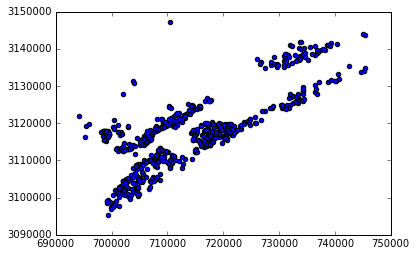

In [27]:
plt.scatter(wc_2010['X'], wc_2010['Y'])
plt.show()

In [28]:
def wc_by_year(year):
    wc_year = wc_gp[wc_gp['Year']==year]
    plt.scatter(wc_year['X'], wc_year['Y'])
    plt.show()

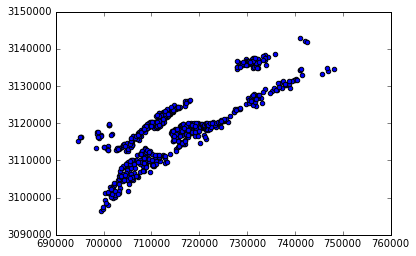

In [31]:
wc_by_year(2007)

In [41]:
import urllib2
from bs4 import BeautifulSoup as bs


page = urllib2.urlopen('http://www.gbif.org/occurrence/search?q=gulo+gulo&year=2015&offset=40')
soup = bs(page.read())

#which of course can be a one-liner if you prefer
# soup = bs(urlopen('string of a real url goes here').read())

/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Users/soph/anaconda/envs/py27/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [74]:
# soup.prettify()
# <tr class="result tableView">
results_table = soup.findAll("tr", { "class" : "result tableView" })
results_table[1]
print(len(results_table))

20


In [71]:
str(results_table[0].td.nextSibling.nextSibling.div.nextSibling.nextSibling.contents[0]).replace('\n',' ').strip()

'61.97N, 12.20E'

In [73]:
str(results_table[0].td.nextSibling.nextSibling.nextSibling.nextSibling.nextSibling.nextSibling.contents[0]).replace('\n',' ').strip().replace(' ','')

'11/2015'

In [281]:
coords = []
dates = []
#2015:1080, 2014:1180, 2013:1180, 2012:980, 2011:1000, 2010:860, 2009:700, 2008:1040

for x in range(0,700,20):
# for x in range(0,60,20):
    page = urllib2.urlopen('http://www.gbif.org/occurrence/search?q=gulo+gulo&year=2009&offset={}'.format(x))
    soup = bs(page.read())
    results_table = soup.findAll("tr", { "class" : "result tableView" })
#     print(results_table[0])
    for i in range(len(results_table)):
        try:
            coords.append(str(results_table[i].td.nextSibling.nextSibling.div.nextSibling.nextSibling.contents[0]).replace('\n',' ').strip())
            dates.append(str(results_table[i].td.nextSibling.nextSibling.nextSibling.nextSibling.nextSibling.nextSibling.contents[0]).replace('\n',' ').strip().replace(' ',''))
        except:
            continue

In [282]:
print coords[0].split(',')[1][1:]

20.08E


In [283]:
print len(dates)
print len(coords)

694
694


In [284]:
lat = []
lng = []
for i in range(len(coords)):
#     print coords[i]
    if len(coords[i].split(','))==2:
        lat.append(coords[i].split(',')[0][:-1])
        lng.append(coords[i].split(',')[1][1:-1])
    else:
        lat.append(0)
        lng.append(0)

In [285]:
lat = np.array(lat)
lng = np.array(lng)
dates = np.array(dates)

In [286]:
wolv_data = pd.DataFrame(np.vstack((lat,lng,dates)).T, columns=['lat','lng','dates'])

In [287]:
wolv_data['lng'] = pd.to_numeric(wolv_data['lng'])
wolv_data['lat'] = pd.to_numeric(wolv_data['lat'])
wolv_data['dates'] = pd.to_datetime(wolv_data['dates'])

In [288]:
wolv_data = wolv_data[(wolv_data['lng']<=40) & (wolv_data['lat']>=50)]

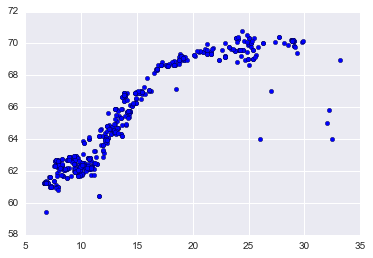

In [4]:
plt.scatter(wolv_data['lng'].values.astype('float64'),wolv_data['lat'].values.astype('float64'))

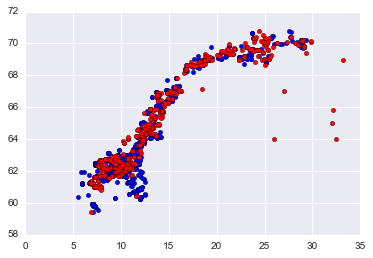

In [11]:
plt.scatter(wolv_data['lng'].values.astype('float64'),wolv_data['lat'].values.astype('float64'))
plt.scatter(wolv_data_2['lng'].values.astype('float64'),wolv_data_2['lat'].values.astype('float64'), c='r')

In [35]:
wolv_data = pd.read_csv('./wolv_2015.csv')
wolv_data = wolv_data.drop(['Unnamed: 0'], axis=1)
wolv_data.head()

,lat,lng,dates
0,61.79,9.93,9/2015
1,61.77,10.11,9/2015
2,61.33,11.10,4/2015
3,69.11,20.11,12/2015
4,69.31,21.21,12/2015


In [36]:
wolv_data.to_csv('./wolv_2015.csv', index=False)

In [12]:
wolv_data['dates'] = pd.to_datetime(wolv_data['dates'])

In [14]:
wolv_data['month'] = wolv_data.apply(lambda row: row['dates'].month, axis=1)

In [18]:
np.sort(wolv_data.month.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

IndexError: list index out of range

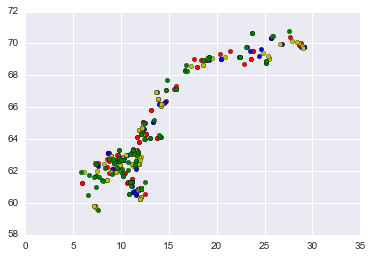

In [19]:
colors=['k','r','b','y','g']
for i in np.sort(wolv_data.month.unique())[:5]:
    plt.scatter(wolv_data[wolv_data['month']==i]['lng'].values.astype('float64'),wolv_data[wolv_data['month']==i]['lat'].values.astype('float64'), c=colors[i])

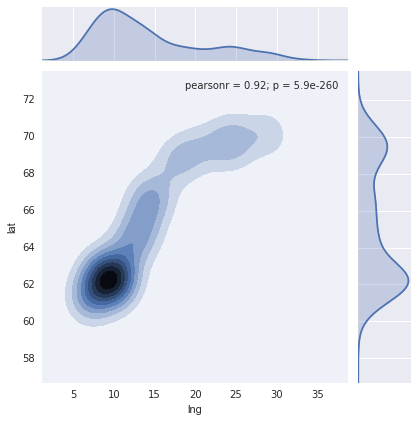

In [291]:
sns.jointplot(x="lng", y="lat", data=wolv_data, kind="kde");

In [254]:
x_grid = np.linspace(np.min(wolv_data['lng']),np.max(wolv_data['lng']),50)
y_grid = np.linspace(np.min(wolv_data['lat']),np.max(wolv_data['lat']),50)
X,Y = np.meshgrid(x_grid, y_grid)

In [255]:
eval_pts = np.vstack((X.flatten(), Y.flatten()))

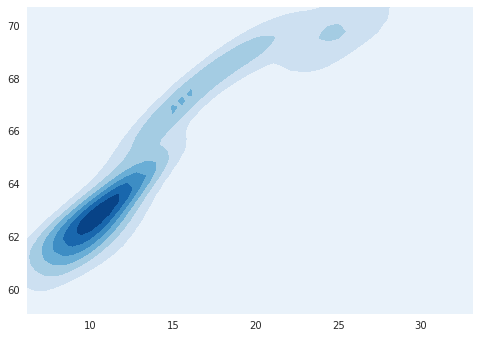

In [256]:
scipy_kde = gaussian_kde(wolv_data[['lng','lat']].T)
values = scipy_kde.evaluate(eval_pts)
cmap = plt.cm.get_cmap("Blues")
plt.contourf(X,Y, values.reshape(50,50), cmap=cmap)

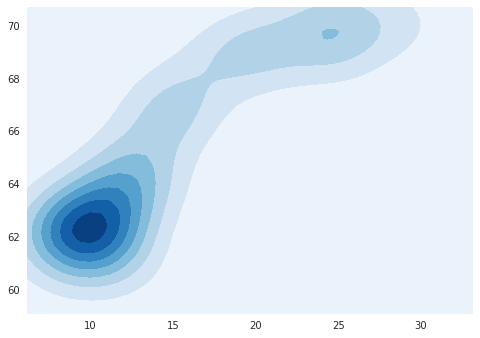

In [257]:
statsmodel_kde = KDEMultivariate(wolv_data[['lng','lat']], var_type='cc')
values = statsmodel_kde.pdf(eval_pts)
plt.contourf(X,Y, values.reshape(50,50), cmap=cmap)

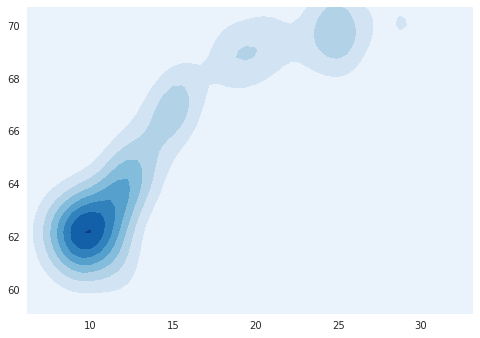

In [258]:
sklearn_kde = KernelDensity()
sklearn_kde.fit(wolv_data[['lng','lat']])
log_values = sklearn_kde.score_samples(eval_pts.T)
values = np.exp(log_values)
plt.contourf(X,Y, values.reshape(50,50), cmap=cmap)

IndexError: tuple index out of range

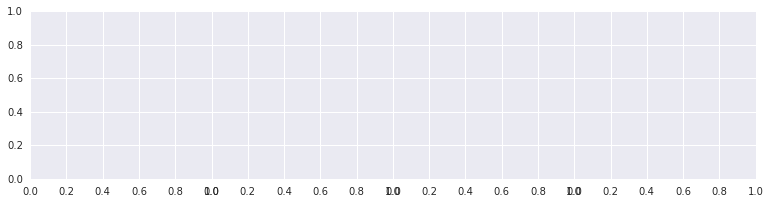

In [227]:
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(-4.5, 3.5)